<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/NewApp_Dec27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries


In [1]:
!pip install datasets -q
!pip install torchmetrics

import os
import glob
import random
from PIL import Image
from torch.utils.data import Dataset, random_split
from datasets import Dataset, DatasetDict
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 32.5 MB/s eta 0:00:00


# Step 2: Add Checkpoints


In [2]:
from google.colab import drive
drive.mount('/content/drive')

model_name = "video-xlstm-1"
CHECKPOINTS_DIR = '/content/drive/MyDrive/ckpts'

def save_checkpoint(model, optimizer, epoch):
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    checkpoint_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved for {model_name} at epoch {epoch}.")

def load_checkpoint(model, optimizer):
    ckpt_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    if not os.path.exists(ckpt_path):
        print(f"No checkpoint found for {model_name}, starting from epoch 0.")
        return 0

    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded for {model_name} from {ckpt_path}. Resuming from epoch {start_epoch}.")
    return start_epoch


Mounted at /content/drive


# Step 3: Add Dataset

In [3]:
!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("pevogam/ucf101-frames")
print("Path to dataset files:", path)


100%|██████████| 8.85G/8.85G [07:07<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pevogam/ucf101-frames/versions/2


# Step 4: Prepare Image Dataset

276255
9


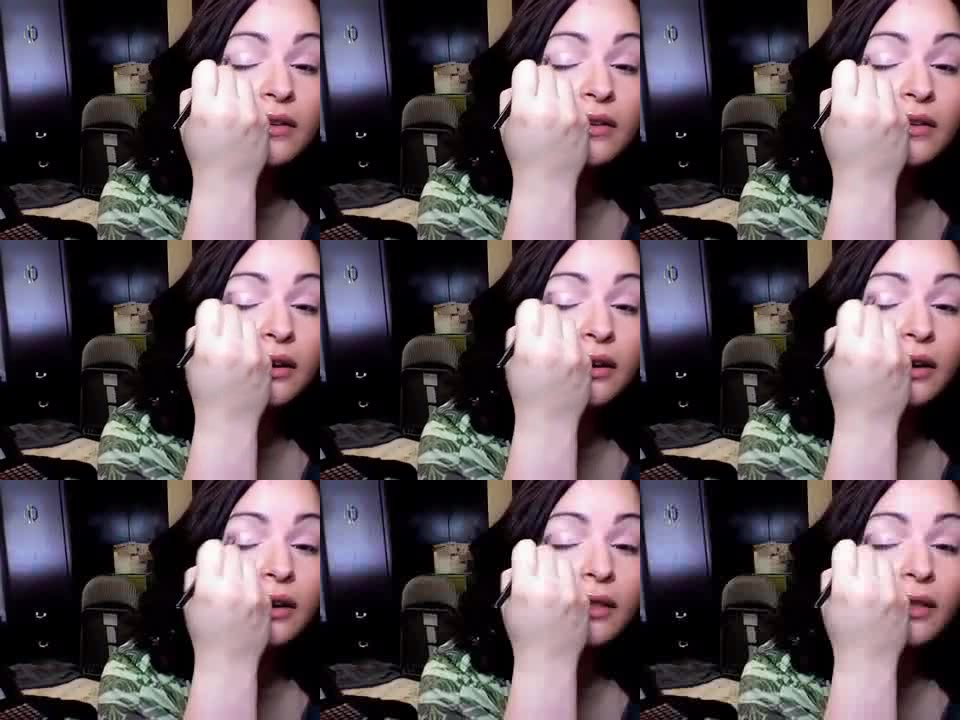

In [4]:
file_list = sorted(glob.glob(os.path.join(path, '**', '*.jpg'), recursive=True))
grouped = [file_list[i:i + 9] for i in range(0, len(file_list), 9)]

class ImageGridDataset(Dataset):
    def __init__(self, image_groups, transform=None):
        self.image_groups = image_groups
        self.transform = transform

    def __len__(self):
        return len(self.image_groups)

    def __getitem__(self, idx):
        image_paths = self.image_groups[idx]
        images = [Image.open(path).convert("RGB") for path in image_paths]
        if self.transform:
            images = [self.transform(img) for img in images]
        grid_image = self._create_grid(images)
        return grid_image

    def _create_grid(self, images):
        assert len(images) == 9, "There must be exactly 9 images to create a 3x3 grid."
        width, height = images[0].size
        grid_width, grid_height = width * 3, height * 3
        grid_image = Image.new("RGB", (grid_width, grid_height))
        for idx, img in enumerate(images):
            x_offset = (idx % 3) * width
            y_offset = (idx // 3) * height
            grid_image.paste(img, (x_offset, y_offset))
        return grid_image

print(len(grouped))
print(len(grouped[0]))
dataset = ImageGridDataset(grouped)
grid_image = dataset[0]
grid_image
